## Executive summary: The goal of this notebook is to use time series analysis to forecast demand, including seasonal trends, of question volume. Data is publicly available from Career Village (https://www.careervillage.org/)
- Note: this model is for educational purposes only and should not be relied upon for business decisions
- Author: Will Merline

### Import data

In [228]:
## Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import seaborn as sns

In [ ]:
# Import 'questions' dataset:
questions = pd.read_csv("Data/questions.csv")
questions

In [ ]:
questions.describe(include='all')

In [ ]:
# Import 'questions_scores' dataset:
questions_scores = pd.read_csv("Data/question_scores.csv")
questions_scores

In [232]:
# Merge datasets:
df_questions = pd.merge(questions, questions_scores, how = 'inner', left_on= 'questions_id', right_on='id')

In [ ]:
# View combined dataframe:
df_questions

In [234]:
# Drop 'id' column, no longer needed:
df_questions = df_questions.drop(columns='id')

In [235]:
# Check for missing values:
df_questions.isnull().sum()

questions_id            0
questions_author_id     0
questions_date_added    0
questions_title         0
questions_body          0
score                   0
dtype: int64

### Deal with date formats

In [ ]:
# Date column formatted as YYYY-MM-DD:
df_questions

In [ ]:
# Remove UTC for easier date parsing:
df_questions2 = df_questions.copy()
df_questions2['questions_date_added'] = df_questions2['questions_date_added'].str.rstrip('UTC+0000')
df_questions2

In [238]:
# Convert data to time series:
df_questions2['Date'] = pd.to_datetime(df_questions2.questions_date_added, format = '%Y-%m-%d %H:%M:%S')

In [ ]:
# Extract Year and Month from Date column:
df_questions2['Month_Year'] = pd.to_datetime(df_questions2['Date']).dt.strftime('%Y-%m')
df_questions2['Year'] = pd.to_datetime(df_questions2['Date']).dt.strftime('%Y')
df_questions2['Month'] = pd.to_datetime(df_questions2['Date']).dt.strftime('%m')
df_questions2['Quarter'] = pd.to_datetime(df_questions2['Date']).dt.quarter
df_questions2['Day_of_week'] = pd.to_datetime(df_questions2['Date']).dt.day_name()
df_questions2

In [240]:
df_questions2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23928 entries, 0 to 23927
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   questions_id          23928 non-null  object        
 1   questions_author_id   23928 non-null  object        
 2   questions_date_added  23928 non-null  object        
 3   questions_title       23928 non-null  object        
 4   questions_body        23928 non-null  object        
 5   score                 23928 non-null  int64         
 6   Date                  23928 non-null  datetime64[ns]
 7   Month_Year            23928 non-null  object        
 8   Year                  23928 non-null  object        
 9   Month                 23928 non-null  object        
 10  Quarter               23928 non-null  int64         
 11  Day_of_week           23928 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 2.4+ MB


In [241]:
# Export to CSV:
df_questions2.to_csv(r'Questions_Data.csv', index=False, header=True)

### Exploratory data analysis

In [242]:
# Group number of questions posed by: 
q_count_day = df_questions2['questions_id'].groupby(df_questions2['Day_of_week']).agg('count')

q_count_day

Day_of_week
Friday       3948
Monday       3098
Saturday     1940
Sunday       1619
Thursday     3973
Tuesday      4577
Wednesday    4773
Name: questions_id, dtype: int64

In [243]:
df_questions2['questions_id'].agg('count')

23928

In [244]:
# Group number of questions posed by quarter:

q_count = df_questions2['questions_id'].groupby(df_questions2.Date.dt.to_period('Q')).agg('count')

In [ ]:
q_count

In [246]:
# # Get average question score by date:
q_avg_score = df_questions2['score'].groupby(df_questions2.Date.dt.to_period('Q')).mean()

In [ ]:
q_avg_score

In [248]:
# Combine question count and average score:
df_q = pd.merge(q_count, q_avg_score, right_index=True, left_index=True)
df_q

,questions_id,score
Date,,
2011Q3,7,4.142857
2011Q4,22,4.545455
2012Q1,203,4.231527
2012Q2,62,2.709677
2012Q3,124,2.758065
2012Q4,46,3.760870
2013Q1,56,3.375000
2013Q2,37,3.108108
2013Q3,19,5.105263


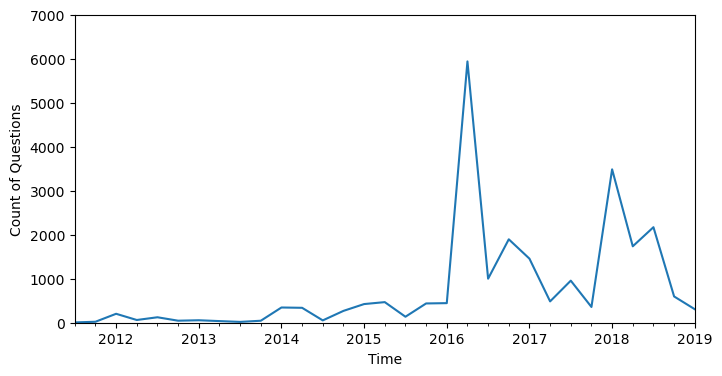

In [249]:
# Plot question count:

plt.figure(figsize=(8,4))
ax= df_q['questions_id'].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Count of Questions')
ax.set_ylim(0,7000)
plt.show()

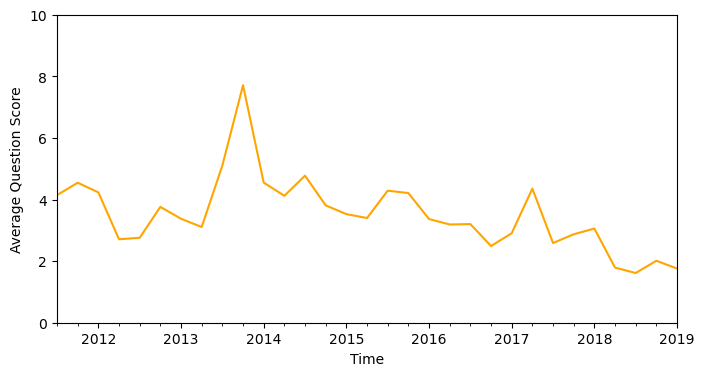

In [250]:
# Plot average question score:

plt.figure(figsize=(8,4))
ax= df_q['score'].plot(color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Average Question Score')
ax.set_ylim(0,10)
plt.show()

### Data partition

In [ ]:
#df_q = df_q.drop(columns='level_0')

df_q = df_q.reset_index().rename(columns={'Date':'Datetime',
                                         'questions_id':'Num_questions', 
                                          'score':'Avg_score'})

#df_q = df_q.drop(columns=['level_0','index'])
df_q

In [252]:
df_q

,Datetime,Num_questions,Avg_score
0,2011Q3,7,4.142857
1,2011Q4,22,4.545455
2,2012Q1,203,4.231527
3,2012Q2,62,2.709677
4,2012Q3,124,2.758065
5,2012Q4,46,3.760870
6,2013Q1,56,3.375000
7,2013Q2,37,3.108108
8,2013Q3,19,5.105263
9,2013Q4,45,7.711111


In [253]:
# Convert to time series:
questions_ts = pd.Series(df_q.Num_questions.values,
                        index=df_q.Datetime,
                        name='Questions_volume')

In [ ]:
questions_ts
# questions_ts.loc['2012Q1':]

In [255]:
# Number of months in dataset
len(questions_ts)

31

In [256]:
# Data partition the time series data:
  ## Keep the last TWO years (8 quarter) data as validation set:

nValid = 9
nTrain = len(questions_ts) - nValid
train_ts = questions_ts[:nTrain]
valid_ts = questions_ts[nTrain:]

In [257]:
# Add month index for each year for trend analysis:
from statsmodels.tsa import tsatools, stattools
import statsmodels.formula.api as sm
ts_df = tsatools.add_trend(questions_ts, trend = 'ct')
ts_df['Quarter'] = ts_df.index.quarter
ts_df

,Questions_volume,const,trend,Quarter
Datetime,,,,
2011Q3,7,1.0,1.0,3
2011Q4,22,1.0,2.0,4
2012Q1,203,1.0,3.0,1
2012Q2,62,1.0,4.0,2
2012Q3,124,1.0,5.0,3
2012Q4,46,1.0,6.0,4
2013Q1,56,1.0,7.0,1
2013Q2,37,1.0,8.0,2
2013Q3,19,1.0,9.0,3


In [258]:
valid_ts

Datetime
2017Q1    1456
2017Q2     485
2017Q3     956
2017Q4     358
2018Q1    3486
2018Q2    1737
2018Q3    2171
2018Q4     597
2019Q1     307
Freq: Q-DEC, Name: Questions_volume, dtype: int64

In [259]:
# Data partition the training and test dataframes:
train_df = ts_df[:nTrain]
valid_df = ts_df[nTrain:]

In [260]:
# Check data partition:
print(len(train_ts))
print(len(valid_ts))

print(len(train_df))
print(len(valid_df))

22
9
22
9


### Time Series models

In [261]:
# Model 1: linear trend regression model:

from statsmodels.tsa import tsatools, stattools
import statsmodels.formula.api as sm

questions_lm = sm.ols(formula = 'Questions_volume ~ trend', data=train_df).fit()
questions_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Questions_volume   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     6.721
Date:                Mon, 18 Dec 2023   Prob (F-statistic):             0.0174
Time:                        14:34:26   Log-Likelihood:                -184.82
No. Observations:                  22   AIC:                             373.6
Df Residuals:                      20   BIC:                             375.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -569.2078    498.560     -1.142      0.267   -1609.185     470.769
trend         98.4094     37.960      2.592      0.017      19.227     177.592
==============================================================================
Omnibus:                       43.267   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.016
Skew:                           3.311   Prob(JB):                     1.79e-35
Kurtosis:                      14.433   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [262]:
# Model 1 evaluation:
predict_lm = questions_lm.predict(valid_df)

RMSE1 = np.sqrt(mean_squared_error(valid_ts, predict_lm))
MAE1 = mean_absolute_error(valid_ts, predict_lm)
MAPE1 = mean_absolute_percentage_error(valid_ts, predict_lm) * 100

print('Model 1 Mean squared error (RMSE):', RMSE1)
print('Model 1 Mean absolute error (MAE):', MAE1)
print('Model 1 Mean Absolute Percentage Error (MAPE):', MAPE1)

Model 1 Mean squared error (RMSE): 1307.6901940665666
Model 1 Mean absolute error (MAE): 1114.879666227492
Model 1 Mean Absolute Percentage Error (MAPE): 213.12990444124873


In [263]:
# Model 2: Seasonality model without trend:
questions_lm_seasonal = sm.ols(formula = 'Questions_volume ~ C(Quarter)', data=train_df).fit()
questions_lm_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Questions_volume   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.8828
Date:                Mon, 18 Dec 2023   Prob (F-statistic):              0.469
Time:                        14:34:26   Log-Likelihood:                -186.50
No. Observations:                  22   AIC:                             381.0
Df Residuals:                      18   BIC:                             385.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         294.8000    574.663      0.513      0.614    -912.523    1502.123
C(Quarter)[T.2]  1074.2000    812.697      1.322      0.203    -633.213    2781.613
C(Quarter)[T.3]   -71.4667    778.098     -0.092      0.928   -1706.190    1563.257
C(Quarter)[T.4]   157.8667    778.098      0.203      0.841   -1476.857    1792.590
==============================================================================
Omnibus:                       34.366   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.453
Skew:                           2.670   Prob(JB):                     1.02e-19
Kurtosis:                      11.178   Cond. No.                         5.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [264]:
# Model 2 evaluation:
predict_lm_seasonal = questions_lm_seasonal.predict(valid_df)

RMSE2 = np.sqrt(mean_squared_error(valid_ts, predict_lm_seasonal))
MAE2 = mean_absolute_error(valid_ts, predict_lm_seasonal)
MAPE2 = mean_absolute_percentage_error(valid_ts, predict_lm_seasonal) * 100

print('Model 2 Mean squared error (RMSE):', RMSE2)
print('Model 2 Mean absolute error (MAE):', MAE2)
print('Model 2 Mean Absolute Percentage Error (MAPE):', MAPE2)

Model 2 Mean squared error (RMSE): 1366.6329872995561
Model 2 Mean absolute error (MAE): 948.4370370370372
Model 2 Mean Absolute Percentage Error (MAPE): 66.18836600976218


In [265]:
# Model 3: linear trend + seasonality model:
questions_lm_seasonal_trend = sm.ols(formula = 'Questions_volume ~ trend + C(Quarter)', data=train_df).fit()
questions_lm_seasonal_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Questions_volume   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     2.413
Date:                Mon, 18 Dec 2023   Prob (F-statistic):             0.0893
Time:                        14:34:26   Log-Likelihood:                -183.06
No. Observations:                  22   AIC:                             376.1
Df Residuals:                      17   BIC:                             381.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -752.3000    657.078     -1.145      0.268   -2138.613     634.013
C(Quarter)[T.2]   979.0091    716.351      1.367      0.190    -532.360    2490.378
C(Quarter)[T.3]   -71.4667    684.882     -0.104      0.918   -1516.441    1373.508
C(Quarter)[T.4]    62.6758    685.942      0.091      0.928   -1384.536    1509.888
trend              95.1909     38.128      2.497      0.023      14.749     175.633
==============================================================================
Omnibus:                       30.296   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.290
Skew:                           2.370   Prob(JB):                     4.03e-15
Kurtosis:                      10.060   Cond. No.                         60.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
# Model 3 evaluation:
predict_lm_seasonal_trend = questions_lm_seasonal_trend.predict(valid_df)

RMSE3 = np.sqrt(mean_squared_error(valid_ts, predict_lm_seasonal_trend))
MAE3 = mean_absolute_error(valid_ts, predict_lm_seasonal_trend)
MAPE3 = mean_absolute_percentage_error(valid_ts, predict_lm_seasonal_trend) * 100

print('Model 3 Mean squared error (RMSE):', RMSE3)
print('Model 3 Mean absolute error (MAE):', MAE3)
print('Model 3 Mean Absolute Percentage Error (MAPE):', MAPE3)

Model 3 Mean squared error (RMSE): 1362.8216309913023
Model 3 Mean absolute error (MAE): 1176.744107744021
Model 3 Mean Absolute Percentage Error (MAPE): 209.40926610660023


In [267]:
# Model 4: Simple exponential smoothing (SES) model:

from statsmodels.tsa.statespace.dynamic_factor_mq import initialization
from statsmodels.tsa.api import SimpleExpSmoothing 

SES = SimpleExpSmoothing(train_ts, initialization_method = 'estimated').fit()

predict_SES = SES.forecast(len(valid_ts))

In [268]:
# Model 4 evaluation:

RMSE4 = np.sqrt(mean_squared_error(valid_ts, predict_SES))
MAE4 = mean_absolute_error(valid_ts, predict_SES)
MAPE4 = mean_absolute_percentage_error(valid_ts, predict_SES) * 100

print('Model 4 Mean squared error (RMSE):', RMSE4)
print('Model 4 Mean absolute error (MAE):', MAE4)
print('Model 4 Mean Absolute Percentage Error (MAPE):', MAPE4)

Model 4 Mean squared error (RMSE): 1052.7096222585994
Model 4 Mean absolute error (MAE): 902.4529136289518
Model 4 Mean Absolute Percentage Error (MAPE): 151.23844399780495


In [269]:
# Model 5: A simple moving average model
# For example, if rolling window=12, we will use the previous 11 periods average to forecast the 12th period:

ma = train_ts.rolling(4).mean()
ma

Datetime
2011Q3        NaN
2011Q4        NaN
2012Q1        NaN
2012Q2      73.50
2012Q3     102.75
2012Q4     108.75
2013Q1      72.00
2013Q2      65.75
2013Q3      39.50
2013Q4      39.25
2014Q1     111.75
2014Q2     187.25
2014Q3     195.75
2014Q4     251.75
2015Q1     271.25
2015Q2     303.50
2015Q3     324.25
2015Q4     366.50
2016Q1     371.75
2016Q2    1739.50
2016Q3    1955.75
2016Q4    2320.25
Freq: Q-DEC, Name: Questions_volume, dtype: float64

In [270]:
# Obtain the last moving average in the training period:
  ## date: 2017-01 
last_ma = ma[-1]
last_ma

2320.25

In [271]:
# Forecast based on last_ma:
predict_ma = pd.Series(last_ma, index = valid_ts.index)
predict_ma

Datetime
2017Q1    2320.25
2017Q2    2320.25
2017Q3    2320.25
2017Q4    2320.25
2018Q1    2320.25
2018Q2    2320.25
2018Q3    2320.25
2018Q4    2320.25
2019Q1    2320.25
Freq: Q-DEC, dtype: float64

In [272]:
# Model 5 evaluation:

RMSE5 = np.sqrt(mean_squared_error(valid_ts, predict_ma))
MAE5 = mean_absolute_error(valid_ts, predict_ma)
MAPE5 = mean_absolute_percentage_error(valid_ts, predict_ma) * 100

print('Model 5 Mean squared error (RMSE):', RMSE5)
print('Model 5 Mean absolute error (MAE):', MAE5)
print('Model 5 Mean Absolute Percentage Error (MAPE):', MAPE5)

Model 5 Mean squared error (RMSE): 1436.4643733254693
Model 5 Mean absolute error (MAE): 1295.638888888889
Model 5 Mean Absolute Percentage Error (MAPE): 238.5450409406312


### ARIMA models

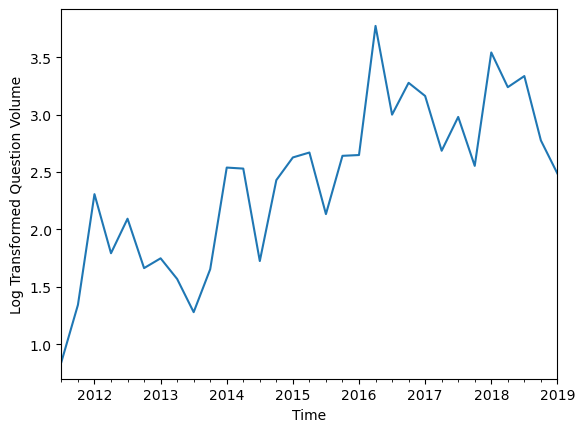

In [273]:
# Log transformation to achieve (more) constant variance

question_ts_log = np.log10(questions_ts)

ax = question_ts_log.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Log Transformed Question Volume')
plt.show()

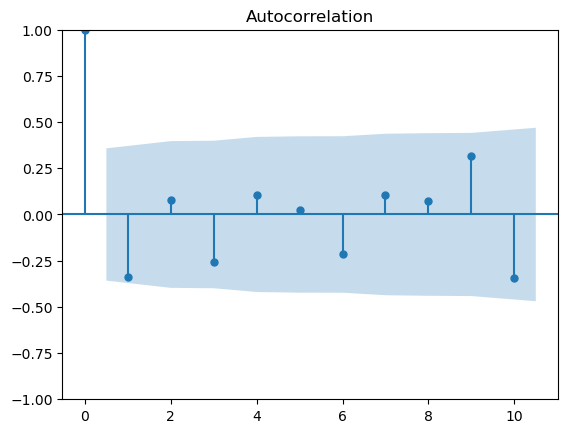

In [274]:
# Plot ACF to check potential seasonality
    ## ACF: autocorrelation factor:
import statsmodels.tsa.api as smt

question_ts_log_diff = question_ts_log.diff(periods=1)

question_ts_log_diff.dropna(inplace=True)

smt.graphics.plot_acf(question_ts_log_diff,
                      lags=10,  #can be number of time periods
                      alpha=0.05)

plt.show()

In [275]:
# Log transform training and validation data:

train_ts_log = np.log10(train_ts)
valid_ts_log = np.log10(valid_ts)

In [276]:
# Identify the best fit ARIMA model:
import itertools

# Define the p, d, q parameters to take any value b/w 0 and 2:

p = d = q = range(0,2)

In [277]:
# Generate all possible combinations of p, d and q triplets:

pdq = list(itertools.product(p,d,q))

# Generate all possible combinations of seasonal p, d and q triplets:

seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p,d,q))]

In [278]:
# Display possible combinations:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [279]:
# Display seasonal p, d and q combinations:
seasonal_pdq

[(0, 0, 0, 4),
 (0, 0, 1, 4),
 (0, 1, 0, 4),
 (0, 1, 1, 4),
 (1, 0, 0, 4),
 (1, 0, 1, 4),
 (1, 1, 0, 4),
 (1, 1, 1, 4)]

In [280]:
import sys

# Specify to ignore warning messages:
import warnings
warnings.filterwarnings("ignore")

# Set-up initial values:
best_aic = np.inf   #infinity
best_pdq = None     #start at baseline (None)
best_seasonal_pdq = None
temp_model = None

import statsmodels.api as sm
# Use loops to search for the best ARIMA model
  ## Choose the best ARIMA model based on minimum AIC values
  ## AIC: to balance the model between goodness-of-fit and number of parameters

for param in pdq:
  for param_seasonal in seasonal_pdq:

    try:
      temp_model = sm.tsa.statespace.SARIMAX(train_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
      results = temp_model.fit()

      if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param
        best_seasonal_pdq = param_seasonal
      
    except:
      continue

# print results and pass variables int ptrint statement using {}s:
print("Best SARIMAX{}x{}4 model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))

Best SARIMAX(0, 1, 1)x(1, 1, 0, 4)4 model - AIC:30.20230018483124


In [281]:
# Display best ARIMA model detailed results:
best_model = sm.tsa.statespace.SARIMAX(train_ts_log,
                                       order=(0,1,1), #Update
                                       seasonal_order = (1,1,0,4), #Update
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)

best_results = best_model.fit()

In [282]:
# Display coefficients for the AR & MA components
    ## sigma square: variance of residuals:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                   Questions_volume   No. Observations:                   22
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 4)   Log Likelihood                 -12.101
Date:                            Mon, 18 Dec 2023   AIC                             30.202
Time:                                    14:34:30   BIC                             32.702
Sample:                                09-30-2011   HQIC                            30.451
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6885      0.444     -1.551      0.121      -1.559       0.182
ar.S.L4       -0.6764      0.259   

In [283]:
# Forecast sales using the best ARIMA model
    # alpha=0.05, 95% confidence intervals: 
pred = best_results.get_forecast(steps=9, alpha=0.05)  # Validation dataset is 2 years (24 months)
pred

In [284]:
ARIMA = np.power(10, pred.predicted_mean)

In [285]:
# Evaluate the best ARIMA model performance:


# Covert back from log transformed data
#regressionSummary(np.power(10, valid_ts),
 #                 np.power(10, pred.predicted_mean))


RMSE6 = np.sqrt(mean_squared_error(np.power(10, valid_ts_log), ARIMA))
MAE6 = mean_absolute_error(np.power(10, valid_ts_log), ARIMA)
MAPE6 = mean_absolute_percentage_error(np.power(10, valid_ts_log), ARIMA) * 100

print('Model 6 Mean squared error (RMSE):', RMSE6)
print('Model 6 Mean absolute error (MAE):', MAE6)
print('Model 6 Mean Absolute Percentage Error (MAPE):', MAPE6)

Model 6 Mean squared error (RMSE): 16586.90569908676
Model 6 Mean absolute error (MAE): 11068.062023305027
Model 6 Mean Absolute Percentage Error (MAPE): 1724.180663483023


### Model visualizations

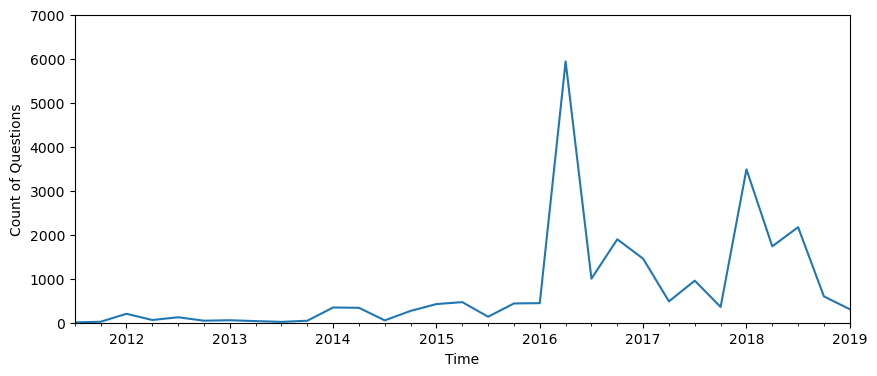

In [286]:
# Plot Question Volume:

plt.figure(figsize=(10,4))
ax= questions_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Count of Questions')
ax.set_ylim(0,7000)
plt.show()

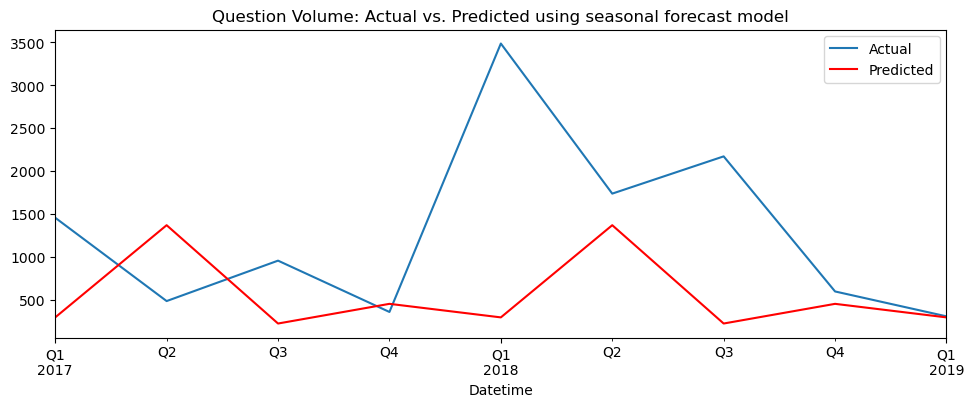

In [287]:
# Plot actuals vs. predicted values for Question Volume:

plt.figure(figsize=(11.5,4))

valid_ts.plot(label='Actual')
predict_lm_seasonal.plot(label='Predicted', color='red')

plt.title('Question Volume: Actual vs. Predicted using seasonal forecast model')
plt.legend()

In [288]:
valid_ts

Datetime
2017Q1    1456
2017Q2     485
2017Q3     956
2017Q4     358
2018Q1    3486
2018Q2    1737
2018Q3    2171
2018Q4     597
2019Q1     307
Freq: Q-DEC, Name: Questions_volume, dtype: int64

In [289]:
# Model 2 evaluation:
predict_lm_seasonal = questions_lm_seasonal.predict(valid_df)
predict_lm_seasonal

Datetime
2017Q1     294.800000
2017Q2    1369.000000
2017Q3     223.333333
2017Q4     452.666667
2018Q1     294.800000
2018Q2    1369.000000
2018Q3     223.333333
2018Q4     452.666667
2019Q1     294.800000
Freq: Q-DEC, dtype: float64

In [290]:
# Create forecast dataset based on seasonal model:

data_future = [['2019Q1', 307], ['2019Q2', 1369.00], ['2019Q3', 223.333333], ['2019Q4', 452.666667], 
               ['2020Q1',294.800000], ['2020Q2',1369.00], ['2020Q3', 223.333333], ['2020Q4', 452.666667]]

### Forecast future time periods

In [291]:
# Create dataframe with future time periods:

future_timestamps = pd.date_range(start='2019-01-01', end='2020-12-31', freq='Q')

future_data = pd.DataFrame(index=future_timestamps)
future_data['year'] = future_data.index.year
future_data['Quarter'] = future_data.index.quarter

future_data['Datetime'] = pd.PeriodIndex(future_data.index, freq='Q')

#future_data['month'] = future_data.index.month
#future_data['day'] = future_data.index.day

In [292]:
# View future periods dataframe:
future_data

,year,Quarter,Datetime
2019-03-31,2019,1,2019Q1
2019-06-30,2019,2,2019Q2
2019-09-30,2019,3,2019Q3
2019-12-31,2019,4,2019Q4
2020-03-31,2020,1,2020Q1
2020-06-30,2020,2,2020Q2
2020-09-30,2020,3,2020Q3
2020-12-31,2020,4,2020Q4


In [293]:
# Make predictions for future periods:
future_predictions = questions_lm_seasonal.predict(future_data[['year', 'Quarter']])
future_predictions

2019-03-31     294.800000
2019-06-30    1369.000000
2019-09-30     223.333333
2019-12-31     452.666667
2020-03-31     294.800000
2020-06-30    1369.000000
2020-09-30     223.333333
2020-12-31     452.666667
dtype: float64

In [294]:
# Convert future predictions to dataframe:
future_predictions_df = pd.DataFrame(index=future_timestamps, data={'Question_volume': future_predictions})

# Format index as YYYY-Q#:
future_predictions_df.index = future_predictions_df.index.to_period('Q').strftime('%YQ%q')

# Add column for merging with original dataset:

future_predictions_df['Datetime'] = pd.PeriodIndex(future_data.index)
future_predictions_df

,Question_volume,Datetime
2019Q1,294.800000,2019Q1
2019Q2,1369.000000,2019Q2
2019Q3,223.333333,2019Q3
2019Q4,452.666667,2019Q4
2020Q1,294.800000,2020Q1
2020Q2,1369.000000,2020Q2
2020Q3,223.333333,2020Q3
2020Q4,452.666667,2020Q4


In [295]:
df_q2 = df_q.copy()
#df_q2

In [ ]:
# Create dataframe with columns from actual question data:
df_q2 = df_q2.rename(columns={'Num_questions':'Question_volume'})

df_q2 = df_q2.drop(columns = ['Avg_score'])

df_q2


In [297]:
# Combine historical questions volume with forecasted volume; needed for visualizations:
df_forecast = pd.merge(df_q2, future_predictions_df, how = 'outer')

In [298]:
# View new dataframe
df_forecast

,Datetime,Question_volume
0,2011Q3,7.000000
1,2011Q4,22.000000
2,2012Q1,203.000000
3,2012Q2,62.000000
4,2012Q3,124.000000
5,2012Q4,46.000000
6,2013Q1,56.000000
7,2013Q2,37.000000
8,2013Q3,19.000000
9,2013Q4,45.000000


In [ ]:
questions_ts

In [ ]:
# Covert dataframe to time series:
forecast_ts = pd.Series(df_forecast.Question_volume.values,
                      index=df_forecast.Datetime,
                      name='Forecasted_questions_volume')

forecast_ts

In [ ]:
# Time series for actual data:
questions_ts

In [302]:
# Covert future predictions dataframe to time series:
future_ts = pd.Series(future_predictions_df.Question_volume.values,
                      index=future_predictions_df.Datetime,
                      name='Predicted_questions_volume')

future_ts

Datetime
2019Q1     294.800000
2019Q2    1369.000000
2019Q3     223.333333
2019Q4     452.666667
2020Q1     294.800000
2020Q2    1369.000000
2020Q3     223.333333
2020Q4     452.666667
Freq: Q-DEC, Name: Predicted_questions_volume, dtype: float64

In [ ]:
future_ts.index.quarter

#### Predictions visualizations

In [ ]:
#  Loop to get 1st quarter and year together, otherwise just quarter
    ## Example Q1 2016, Q2, Q3, Q4, Q1 2017:

l = 0
f_labels = []
for i in forecast_ts.index.quarter:
  y = forecast_ts.index.year[l]
  if i ==1:
    qtr = (f'{"Q"}{i}\n\n{y}')
  else:
    qtr = (f'{"Q"}{i}')
  
  l = l+1
  f_labels.append(qtr)

f_labels

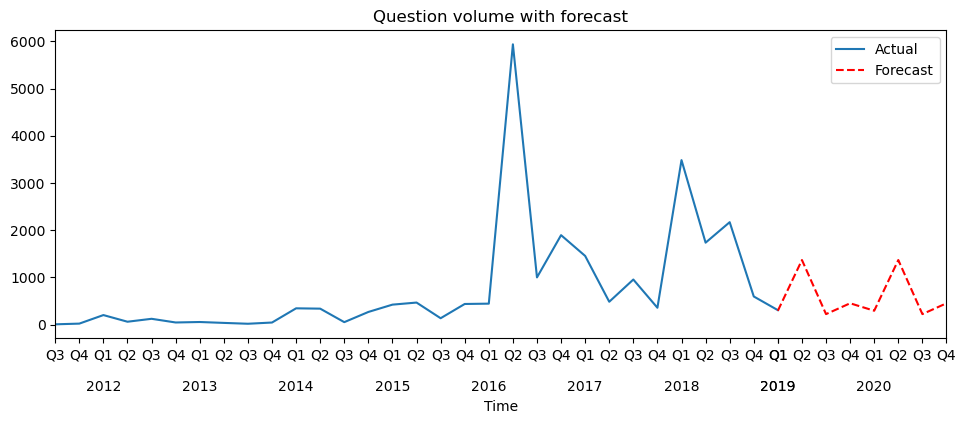

In [305]:
# Plot actuals vs. forecasted values for Question Volume:

plt.figure(figsize=(11.5,4))

q_plot = questions_ts.plot(label='Actual')
f_plot = future_ts.plot(label='Forecast', color='red', linestyle = 'dashed')


q_plot.set_xticks(forecast_ts.index)
q_plot.set_xticks(forecast_ts.index, minor=True)

# Use labels for combined forecast time series
q_plot.set_xticklabels(f_labels)

# labels for questions forecast data

plt.xlabel('Time')
#plt.xticklabels("Q")
plt.title('Question volume with forecast')
plt.legend()

### 
- None of the time series models provide a robust forecast
- The seasonal model accurately captures the spikes around Q1 and Q4 of each year
- An explanation for this spike is that people may be more likely to look for new jobs / careers around the beginning of the year and post more career-related questions around this time


In [306]:
j = 2
y = questions_ts.index.year[j]
y

2012

In [ ]:
#  Loop to get 1st quarter and year together, otherwise just quarter
    ## Example Q1 2016, Q2, Q3, Q4, Q1 2017
j = 0
labels = []
for i in questions_ts.index.quarter:
  y = questions_ts.index.year[j]
  if i ==1:
    qtr = (f'{"Q"}{i}\n\n{y}')
  else:
    qtr = (f'{"Q"}{i}')
  
  j = j+1
  labels.append(qtr)

labels

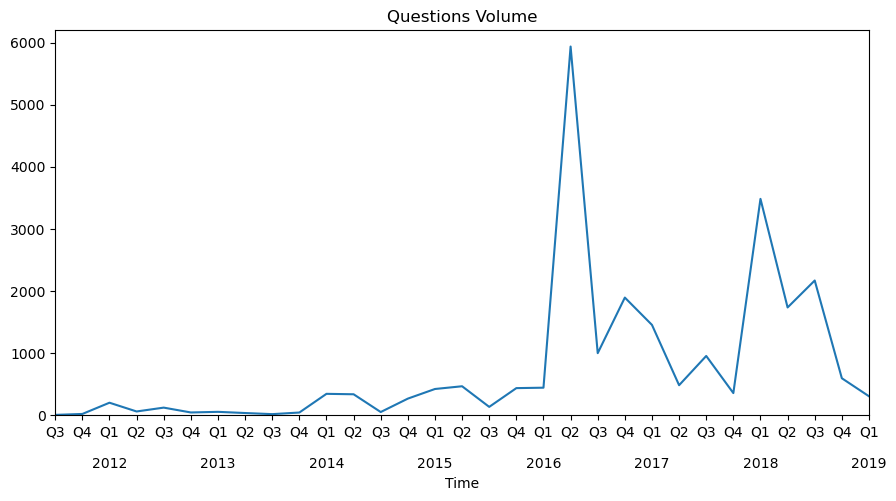

In [308]:
# Plot question count:

plt.figure(figsize=(10.5,5))
ax= questions_ts.plot()
ax.set_xlabel('Time')
#ax.set_ylabel('Count of Questions')
ax.set_ylim(0,6200)


# Set axis labels to show quarterly and yearly periods
ax.set_xticks(questions_ts.index)
ax.set_xticks(questions_ts.index, minor=True)
ax.set_xticklabels(labels)

#ax.set_xticklabels(questions_ts.index)

plt.title('Questions Volume')
plt.show()